In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import re

# initialize a dict to store the data
llm_performance = {
    "GPT": {"accuracy": 0.8334, "recall": 0.8328},
    "LLAMA": {"accuracy": 0.7781, "recall": 0.8219}
}

# example: LR: 0.3024;0.3987;0.3439 -> 0.3987
def get_recall(model_string):
    return float(model_string.split(';')[1])

In [6]:
llm_name = "LLAMA"
dataset_name = "HATESPEECH"
log_dir = f"./paper_logs/{llm_name}/{dataset_name.lower()}-llama-small/"

# get all .log files in the directory
files = [f for f in os.listdir(log_dir) if f.endswith('.log')]
files.sort()
# divide the files into different cascade sizes
cascades = {}
for f in files:
    cascade_size = f.split('_')
    if '_'.join(cascade_size[0:-1]) not in cascades:
        cascades['_'.join(cascade_size[0:-1])] = []
    cascades['_'.join(cascade_size[0:-1])].append(f)
cascades

{'LR_BERT-base': ['LR_BERT-base_0.000001.log',
  'LR_BERT-base_0.000002.log',
  'LR_BERT-base_0.000003.log',
  'LR_BERT-base_0.000004.log',
  'LR_BERT-base_0.000005.log',
  'LR_BERT-base_0.000006.log',
  'LR_BERT-base_0.000007.log',
  'LR_BERT-base_0.000008.log',
  'LR_BERT-base_0.000009.log',
  'LR_BERT-base_0.000010.log',
  'LR_BERT-base_0.000020.log',
  'LR_BERT-base_0.000030.log',
  'LR_BERT-base_0.000040.log',
  'LR_BERT-base_0.000050.log',
  'LR_BERT-base_0.000060.log',
  'LR_BERT-base_0.000070.log',
  'LR_BERT-base_0.000080.log',
  'LR_BERT-base_0.000090.log',
  'LR_BERT-base_0.000100.log',
  'LR_BERT-base_0.000200.log',
  'LR_BERT-base_0.000300.log',
  'LR_BERT-base_0.000400.log',
  'LR_BERT-base_0.000500.log',
  'LR_BERT-base_0.000600.log',
  'LR_BERT-base_0.000700.log',
  'LR_BERT-base_0.000800.log',
  'LR_BERT-base_0.000900.log',
  'LR_BERT-base_0.001000.log',
  'LR_BERT-base_0.002000.log',
  'LR_BERT-base_0.003000.log',
  'LR_BERT-base_0.004000.log',
  'LR_BERT-base_0.00500

In [11]:
def plot_both(cascade_logs, cascade_costs):
    # define figure size
    plt.figure(figsize=(6, 4.5))
    plt.rcParams["font.weight"] = "bold"
    # bold the x and y axis labels
    plt.rcParams["axes.labelweight"] = "bold"
    fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)

    cascade_size = len(cascade_logs[0].split('_')) - 1
    print("cascade size: ", cascade_size)
    costs = []
    accus = []
    linear_accus = []
    # plot the data
    for f in cascade_logs:
        num_lines = sum(1 for line in open(log_dir + f))
        # read last line of the file
        with open(log_dir + f, 'r') as file:
            last_line = file.readlines()[-2]
        # data format: '''m1_prediction, m2_prediction, ..., llm_prediction, ground_truth, m1_proportion, m2_proportion, ..., m1_defer_prob, m2_defer_prob, ..., m1_score, m2_score, ..., m1_accuracy, m2_accuracy, llm_accuracy, overall_accuracy'''
        data = re.split(',', last_line.strip())
        model_prop = []
        linear_combination_acc = 0
        for k in range(cascade_size):
            model_prop.append(float(data[k + cascade_size + 2]))
            linear_combination_acc += float(data[k + cascade_size * 4 + 2]) * float(data[k + cascade_size + 2])
            # print('model proportion: ', float(data[k + cascade_size + 2]), 'model accuracy: ', float(data[k + cascade_size * 4 + 2]))
            
        llm_cost = 1 - sum(model_prop)
        model_accu = []
        for k in range(cascade_size):
            model_accu.append(float(data[k + cascade_size * 4 + 2]))
        llm_accuracy = float(data[k + cascade_size * 4 + 3])
        overall_accuracy = float(data[k + cascade_size * 4 + 4])
        linear_combination_acc += llm_accuracy * llm_cost

        # plt.plot(llm_cost, overall_accuracy, '.')
        # plt.annotate(f.split('_')[-1], (llm_cost, overall_accuracy))
        costs.append(llm_cost * num_lines)
        accus.append(overall_accuracy)
        linear_accus.append(linear_combination_acc)
        # print('llm cost: ', llm_cost, 'Online Ensemble Learning accuracy: ', linear_combination_acc, 'overall accuracy: ', overall_accuracy)

    # sort the data then plot
    costs = np.array(costs)
    accus = np.array(accus)
    idx = np.argsort(costs)
    costs = costs[idx]
    accus = accus[idx]
    axs[0].plot(costs, accus, label = 'Online Cascade Learning Accuracy')
    linear_accus = np.array(linear_accus)
    linear_accus = linear_accus[idx]
    axs[0].plot(costs, linear_accus, label = 'Online Ensemble Learning Accuracy')
    axs[0].set_ylabel('Accuracy', weight='bold', fontsize=16)
    axs[0].set_title(dataset_name, weight='bold', fontsize=20)
    axs[0].axhline(y=llm_performance[llm_name]['accuracy'], color='r', linestyle='--', label = 'GPT_3.5_Turbo')

    plt.xlabel('Cost Budget (number of llm calls)', weight='bold', fontsize=16)

    cascade_size = len(cascade_logs[0].split('_')) - 1
    print("cascade size: ", cascade_size)
    costs = []
    recall = []
    linear_recall = []
    # plot the data
    for f in cascade_logs:
        # read last line of the file
        with open(log_dir + f, 'r') as file:
            last_line = file.readlines()[-2]
        # data format: '''m1_prediction, m2_prediction, ..., llm_prediction, ground_truth, m1_proportion, m2_proportion, ..., m1_defer_prob, m2_defer_prob, ..., m1_score, m2_score, ..., m1_accuracy, m2_accuracy, llm_accuracy, overall_accuracy'''
        data = re.split(',', last_line.strip())
        model_prop = []
        my_recall = 0
        for k in range(cascade_size):
            model_prop.append(float(data[k + cascade_size + 2]))
            my_recall += get_recall(data[k + cascade_size * 6 + 3]) * float(data[k + cascade_size + 2])
            print('recall: ', get_recall(data[k + cascade_size * 6 + 3]), 'model proportion: ', float(data[k + cascade_size + 2]))

        llm_cost = 1 - sum(model_prop)

        llm_recall = get_recall(data[-2])
        my_recall += llm_recall * llm_cost
        overall_recall = get_recall(data[-1])
        # print overall cost and recall
        print(f, 'llm cost: ', llm_cost, 'overall recall: ', overall_recall, 'linear recall: ', my_recall)

        costs.append(llm_cost * num_lines)
        recall.append(overall_recall)
        linear_recall.append(my_recall)

    # sort the data then plot
    costs = np.array(costs)
    recall = np.array(recall)
    idx = np.argsort(costs)
    costs = costs[idx]
    recall = recall[idx]
    axs[1].plot(costs, recall, label = 'Online Cascade Learning')
    linear_recall = np.array(linear_recall)
    linear_recall = linear_recall[idx]
    axs[1].tick_params(axis='x', which='both', bottom=True, top=False, direction='out', length=5, width=1)
    axs[1].plot(costs, linear_recall, label = 'Online Ensemble Learning')
    # axs[1].legend(loc = 'lower right')
    axs[1].set_ylabel('Recall', weight='bold', fontsize=16)
    axs[1].axhline(y=llm_performance[llm_name]['recall'], color='r', linestyle='--', label = 'GPT_3.5_Turbo')

    plt.xlabel('Cost Budget (number of llm calls)')
    plt.title(dataset_name, weight='bold')
    
    # write to pdf file
    size = "small" if cascade_size == 2 else "large"
    plt.savefig(dataset_name + '_' + size + '_' + llm_name + '_cascade.pdf', bbox_inches='tight')
    plt.show()

cascade size:  2
cascade size:  2
recall:  0.4791 model proportion:  0.0299
recall:  0.737 model proportion:  0.0166
LR_BERT-base_0.000001.log llm cost:  0.9535 overall recall:  0.827 linear recall:  0.8272132400000001
recall:  0.4807 model proportion:  0.0273
recall:  0.7538 model proportion:  0.0168
LR_BERT-base_0.000002.log llm cost:  0.9559 overall recall:  0.827 linear recall:  0.82845618
recall:  0.4807 model proportion:  0.0275
recall:  0.7504 model proportion:  0.0166
LR_BERT-base_0.000003.log llm cost:  0.9559 overall recall:  0.827 linear recall:  0.82834512
recall:  0.4807 model proportion:  0.0273
recall:  0.7504 model proportion:  0.0166
LR_BERT-base_0.000004.log llm cost:  0.9561 overall recall:  0.827 linear recall:  0.82841692
recall:  0.4807 model proportion:  0.0277
recall:  0.7487 model proportion:  0.0166
LR_BERT-base_0.000005.log llm cost:  0.9557 overall recall:  0.827 linear recall:  0.8282451000000001
recall:  0.4807 model proportion:  0.029
recall:  0.7521 mode

<Figure size 600x450 with 0 Axes>

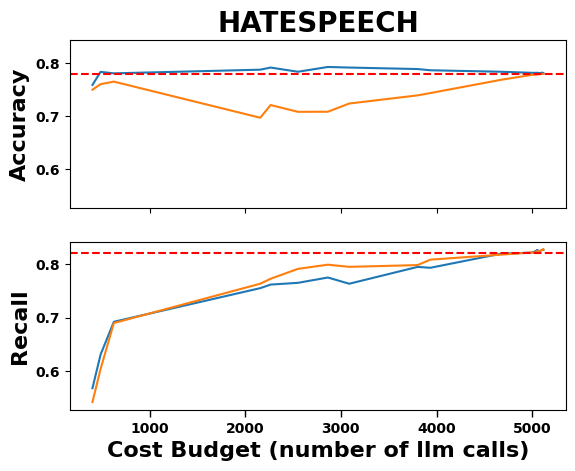

In [12]:
cascade_name = 'LR_BERT-base'
cascade_logs = cascades[cascade_name]
cascade_costs = {
    "GPT": [1, 1182],
    "LLAMA": [1, 636]
}

plot_both(cascade_logs, cascade_costs)

cascade size:  3
cascade size:  3
recall:  0.753 model proportion:  0.0213
recall:  0.7631 model proportion:  0.025
recall:  0.838 model proportion:  0.009
LR_BERT-base_BERT-large_0.00000100.log llm cost:  0.9447 overall recall:  0.8153 linear recall:  0.834317
recall:  0.753 model proportion:  0.0213
recall:  0.7631 model proportion:  0.025
recall:  0.838 model proportion:  0.009
LR_BERT-base_BERT-large_0.00000200.log llm cost:  0.9447 overall recall:  0.8153 linear recall:  0.834317
recall:  0.753 model proportion:  0.0213
recall:  0.7631 model proportion:  0.025
recall:  0.838 model proportion:  0.009
LR_BERT-base_BERT-large_0.00000300.log llm cost:  0.9447 overall recall:  0.8153 linear recall:  0.834317
recall:  0.753 model proportion:  0.0213
recall:  0.7631 model proportion:  0.025
recall:  0.838 model proportion:  0.009
LR_BERT-base_BERT-large_0.00000400.log llm cost:  0.9447 overall recall:  0.8153 linear recall:  0.834317
recall:  0.753 model proportion:  0.0213
recall:  0.76

<Figure size 600x450 with 0 Axes>

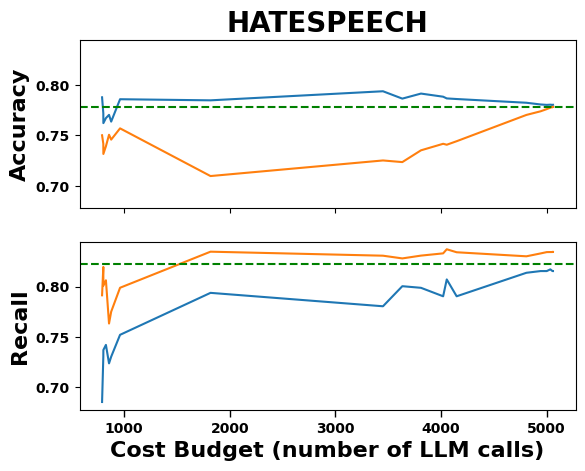

In [22]:
cascade_name = 'LR_BERT-base_BERT-large'
cascade_logs = cascades[cascade_name]
cascade_costs = {
    "GPT": [1, 3, 1182],
    "LLAMA": [1, 3, 636]
}

plot_both(cascade_logs, cascade_costs)